# Heat Transfer in 2D Square Domain- DeepXDE Implementation

## Theoretical Background

### Objective

In the previous tutorial: [heat_transfer_2- 1D rod- DeepXDE.ipynb](https://github.com/neelaydoshi/PINNs-for-Beginners/blob/main/T2-%20Heat_Transfer/heat_transfer_2-%201D%20rod-%20DeepXDE.ipynb), we solved the heat transfer through a 1D rod using the [DeepXDE](https://github.com/lululxvi/deepxde) library. We will now extend this to heat transfer in a 2D square domain.


### Porblem Statement

Let us consider a 2D square of length and width: $L = w = 1.0 \ m$ and thermal conductivity $k = 225 \ W/m.K$. The left wall is at a constant temperature of $100 \degree C$ (Dirichlet boundary condition). The top, bottom and right walls are exposed to the air at a temperature of $T_{\infty} = 10 \degree C$, with a convective heat transfer coefficient of $h = 50\ W/m^2.K$. We wish to compute the steady-state temperature profile within this square domain.

## Import Libraries

In [1]:
import torch
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt  

# Set seed for reproducibility  
dde.config.set_random_seed(42)  

# Nly: Set backend to PyTorch
dde.backend.backend_name = "pytorch"


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


## Select Device: CPU or GPU

**Check if GPU is available :**

In [2]:
# Check if GPU is available
print("#"*17)
print("CUDA available:", torch.cuda.is_available())
print("Default CUDA device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
print("#"*17)
print(f"GPU available for DeepXDE: {dde.backend.is_gpu_available()}")
print("#"*17)


#################
CUDA available: True
Default CUDA device: 0
Device name: NVIDIA GeForce RTX 5060 Laptop GPU
#################
GPU available for DeepXDE: True
#################


**Select Device :**

In [3]:
# Select device for computation
device = "cuda" # must be set for both PyTroch and DeepXDE ("net" variable of DeepXDE)

# Create dummy tensor for testing
torch.set_default_device(device)
a = torch.tensor([1.0, 2.0])

print("#"*17)
print("PyTorch tensors stored in :", a.device)  # Should show: cuda:0
print("#"*17)


#################
PyTorch tensors stored in : cuda:0
#################


## Setup Model

### Initialize Parameters and Geometry

In [4]:
# Problem parameters
k       = 225.0  # W/m.K  
h       = 50.0   # W/m².K  
L       = 1    # m  
w       = 1   # m  
T_inf   = 10.0   # °C
T_wall  = 100.0  # °C

# Define geometry
geom = dde.geometry.Rectangle([0, -w/2], [L, w/2])  


## Governing Equation

### Normalizatoin

As mentioned in the previous tutorials, neural networks converge faster if the inputs and outputs are normalized. Since the dimensions of the square (inputs) are already in the range of $[0,\ 1]$, we only need to normalize the temperature (output).

**Min-max normalization :**
$$ \displaystyle{  \hat{T} = \frac{ T - T_{\infty} }{ T_{wall} - T_{\infty} } } $$

**De-normalized :**
$$ T = \hat{T} \times (T_{wall} - T_{\infty}) + T_{\infty} $$



### Interior Points 

The 2D steady heat conduction equation:

$$ \frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2} = 0 $$

$$
\boxed{
\frac{\partial^2 \hat{T}}{\partial x^2} + \frac{\partial^2 \hat{T}}{\partial y^2} = 0
}
$$


### Governing PDE in DeepXDE 

In [5]:
# Define PDE (Laplace equation: d²T/dx² + d²T/dy² = 0)  
def pde(x, y):  
    T_xx = dde.grad.hessian(y, x, i=0, j=0)  
    T_yy = dde.grad.hessian(y, x, i=1, j=1)  
    return T_xx + T_yy


## Boundary Condition

### Left Wall B.C (Dirichlet)

$$
\begin{align}
\nonumber T_0 &= T_{wall} \\[10pt]
%%
\nonumber \hat{T}_0 \times (T_{wall} - T_{\infty}) + T_{\infty} &= T_{wall} \\[10pt]
%%
\nonumber \hat{T}_0 \times (T_{wall} - T_{\infty}) &= ( T_{wall} - T_{\infty} )
\end{align}
$$

$$
\boxed{
\hat{T}_0 = 1
}
$$


### Right Wall B.C (Convection)

Lets start from energy balance at the right wall:
$$
\begin{align}
%%
\nonumber \dot{Q}_{in} &= \dot{Q}_{out} \\[10pt]
%%
\nonumber \dot{Q}_{\text{in,cond-x}} + \dot{Q}_{\text{in,cond-y}}
&= \dot{Q}_{\text{out,conv-x}} + \dot{Q}_{\text{out,cond-y}} \\[10pt]
%%
\nonumber - k \frac{\partial{T}}{\partial{x}} - k\frac{\partial{T}}{\partial{y}}
&= h(T - T_\infty) - k\frac{\partial{T}}{\partial{y}} \\[10pt]
%%
\nonumber \frac{\partial{T}}{\partial{x}} &= - \frac{h}{k} (T - T_{\infty})
\end{align}
$$

Upon substituting $T$ with its normalized value $\hat{T}$, we get:
$$
\boxed{
\frac{\partial \hat{T}}{\partial x} = - \left( \frac{h}{k} \right) \hat{T}
}
$$

### Top Wall B.C (Convection)

In a manner similar to the right wall, we can derive the governing equation for top wall:

$$
\boxed{
\frac{\partial \hat{T}}{\partial y} = - \left( \frac{h}{k} \right) \hat{T}
}
$$

### Bottom Wall B.C (Convection)

In a manner similar to the right wall, we can derive the governing equation for bottom wall:

$$
\boxed{
\frac{\partial \hat{T}}{\partial y} = - \left( \frac{h}{k} \right) \hat{T}
}
$$

### Definition Boundaries in DeepXDE

In [6]:
# Define boundary condition functions  
def boundary_left(x, on_boundary):  
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], L)

def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], -w/2)

def boundary_top(x, on_boundary):  
    return on_boundary and dde.utils.isclose(x[1], w/2)


### Define Boundary Conditions in DeepXDE

In [7]:
# Boundary conditions  
# Left wall: T_norm = 1 (Dirichlet)  
bc_left = dde.icbc.DirichletBC(geom, lambda x: 1, boundary_left)  
  
# Right wall: dT_norm/dx = -(h/k)*T_norm (Robin)  
bc_right = dde.icbc.RobinBC(geom, lambda x, y: -(h/k) * y, boundary_right)  

# Bottom wall: dT_norm/dy = (h/k)*T_norm (Robin)  
# -> Note: negative sign for outward normal
bc_bottom = dde.icbc.RobinBC(geom, lambda x, y: -(h/k) * y, boundary_bottom)

# Top wall: dT_norm/dy = -(h/k)*T_norm (Robin)  
# -> Note: positive for outward normal
bc_top = dde.icbc.RobinBC(geom, lambda x, y: -(h/k) * y, boundary_top)

# Store all B.C in list
# bcs = [bc_left, bc_right]
bcs = [bc_left, bc_right, bc_bottom, bc_top]


## PINN Setup

### Initialize Network

We will exclude the corner points for simplicity using `exclusions` argument in the `dde.data.PDE()` object.

In [8]:
# Create PDE data and exclude corner vertices  
data = dde.data.PDE(geom, pde, bcs,
                    num_domain=2000, num_boundary=400, num_test=1000,
                    exclusions=[[0, -w/2], [L, -w/2], [0, w/2], [L, w/2]])

# Define neural network
net = dde.nn.FNN([2] + [20]*3 + [1], "tanh", "Glorot normal")

# Send to device
net.to(device)
print("DeepXDE network is on :", next(net.parameters()).device)


DeepXDE network is on : cuda:0


## PINN Training

### Adam Optimizer

In [9]:
# Create and compile model
model = dde.Model(data, net)
model.compile("adam", lr=0.001, decay=("step", 1000, 1.0), loss_weights=[1, 1e3, 1e3, 1e3, 1e3])

# Train the model
losshistory, train_state = model.train(iterations=5_000, display_every=1000)


Compiling model...
'compile' took 0.913664 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [4.11e-02, 1.01e+03, 1.21e+02, 8.29e+01, 9.43e+01]    [3.78e-02, 1.01e+03, 1.21e+02, 8.29e+01, 9.43e+01]    []  


c:\Users\Neelay\miniconda3\envs\train_1\lib\site-packages\torch\autograd\graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [2.44e-01, 3.03e-01, 1.71e-03, 3.36e-03, 1.44e-02]    [2.63e-01, 3.03e-01, 1.71e-03, 3.36e-03, 1.44e-02]    []  
2000      [1.50e-01, 2.98e-01, 7.61e-04, 4.65e-03, 8.94e-03]    [1.60e-01, 2.98e-01, 7.61e-04, 4.65e-03, 8.94e-03]    []  
3000      [5.07e-02, 2.90e-01, 1.89e-03, 6.04e-03, 6.82e-03]    [4.66e-02, 2.90e-01, 1.89e-03, 6.04e-03, 6.82e-03]    []  
4000      [2.65e-02, 2.81e-01, 1.39e-03, 4.36e-03, 7.84e-03]    [2.08e-02, 2.81e-01, 1.39e-03, 4.36e-03, 7.84e-03]    []  
5000      [1.32e-02, 2.73e-01, 1.09e-03, 4.46e-03, 6.84e-03]    [9.54e-03, 2.73e-01, 1.09e-03, 4.46e-03, 6.84e-03]    []  

Best model at step 5000:
  train loss: 2.99e-01
  test loss: 2.95e-01
  test metric: []

'train' took 45.275227 s



## Save and Load Model

**Save Model :**

In [10]:
# Save the model after training  
model.save("saved_models/heat_transfer_3- 2D_square")


'saved_models/heat_transfer_3- 2D_square-5000.pt'

**Load Model :**

In [13]:
# Create the same model structure  
data = dde.data.PDE(geom, pde, bcs, num_domain=2000, num_boundary=400, num_test=1000)  
net = dde.nn.FNN([2] + [20]*3 + [1], "tanh", "Glorot normal") 
model = dde.Model(data, net)
model.compile("adam", lr=0.01)

# Restore the trained weights  
model.restore(r"saved_models/heat_transfer_3- 2D_square-5000.pt")  # Use the full filename with iteration number  


Compiling model...
'compile' took 0.000116 s



### 2D Plot

(np.float64(0.0), np.float64(1.0), np.float64(-0.5), np.float64(0.5))

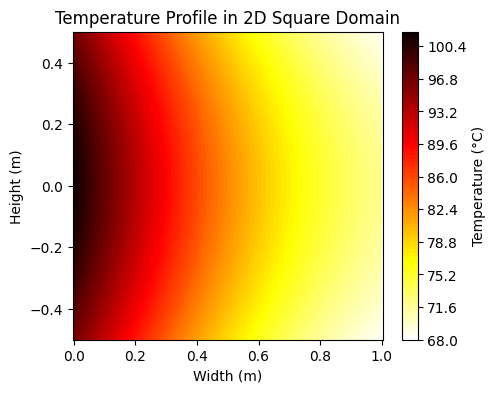

In [14]:
# Create a grid for full 2D visualization  
nx, ny = 100, 50  
x_grid = np.linspace(0, L, nx)
y_grid = np.linspace(-w/2, w/2, ny)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel()])

# Predict temperature on the grid  
T_grid_norm = model.predict(grid_points).reshape(ny, nx)
T_grid      = T_grid_norm*(T_wall - T_inf) + T_inf

# Plot contour
plt.figure(figsize=(5, 4))
contour = plt.contourf(X_grid, Y_grid, T_grid, levels=100, cmap='hot_r') # bwr
# contour = plt.contourf(X_grid, Y_grid, T_grid, levels=100, cmap='hot_r', vmin=50, vmax=110) # bwr
# contour.set_clim(50, 110)  # Optional: ensures colorbar matches the contour plot range
plt.colorbar(contour, label='Temperature (°C)')

plt.xlabel('Width (m)')
plt.ylabel('Height (m)')
plt.title('Temperature Profile in 2D Square Domain')
plt.axis('equal')
